In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2013024, 828)
(2013024, 8)
validation
(321352, 828)
(321352, 8)
test
(172592, 828)
(172592, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/202 [..............................] - ETA: 4:03 - loss: 2.6323 - STD: 0.1208 - MAE: 0.2214

  5/202 [..............................] - ETA: 3s - loss: 2.2460 - STD: 0.0570 - MAE: 0.2193  

  9/202 [>.............................] - ETA: 3s - loss: 2.1781 - STD: 0.0612 - MAE: 0.2172

 13/202 [>.............................] - ETA: 2s - loss: 2.1535 - STD: 0.0609 - MAE: 0.2167

 17/202 [=>............................] - ETA: 2s - loss: 2.1332 - STD: 0.0549 - MAE: 0.2167

 21/202 [==>...........................] - ETA: 2s - loss: 2.1182 - STD: 0.0497 - MAE: 0.2168

 25/202 [==>...........................] - ETA: 2s - loss: 2.1090 - STD: 0.0468 - MAE: 0.2168

 29/202 [===>..........................] - ETA: 2s - loss: 2.1020 - STD: 0.0445 - MAE: 0.2169

 31/202 [===>..........................] - ETA: 5s - loss: 2.0998 - STD: 0.0433 - MAE: 0.2169

 35/202 [====>.........................] - ETA: 5s - loss: 2.0941 - STD: 0.0418 - MAE: 0.2169

 39/202 [====>.........................] - ETA: 4s - loss: 2.0894 - STD: 0.0412 - MAE: 0.2168

 43/202 [=====>........................] - ETA: 4s - loss: 2.0851 - STD: 0.0407 - MAE: 0.2168

 47/202 [=====>........................] - ETA: 4s - loss: 2.0808 - STD: 0.0400 - MAE: 0.2167

 51/202 [======>.......................] - ETA: 4s - loss: 2.0765 - STD: 0.0394 - MAE: 0.2166

 55/202 [=======>......................] - ETA: 3s - loss: 2.0715 - STD: 0.0389 - MAE: 0.2165

 59/202 [=======>......................] - ETA: 3s - loss: 2.0655 - STD: 0.0388 - MAE: 0.2164

 63/202 [========>.....................] - ETA: 3s - loss: 2.0587 - STD: 0.0392 - MAE: 0.2161

 67/202 [========>.....................] - ETA: 3s - loss: 2.0509 - STD: 0.0402 - MAE: 0.2158

 71/202 [=========>....................] - ETA: 3s - loss: 2.0427 - STD: 0.0415 - MAE: 0.2154

 75/202 [==========>...................] - ETA: 2s - loss: 2.0340 - STD: 0.0429 - MAE: 0.2150

 79/202 [==========>...................] - ETA: 2s - loss: 2.0252 - STD: 0.0443 - MAE: 0.2146

 83/202 [===========>..................] - ETA: 2s - loss: 2.0160 - STD: 0.0459 - MAE: 0.2142

 87/202 [===========>..................] - ETA: 2s - loss: 2.0067 - STD: 0.0474 - MAE: 0.2137

 91/202 [============>.................] - ETA: 2s - loss: 1.9976 - STD: 0.0489 - MAE: 0.2133

 95/202 [=============>................] - ETA: 2s - loss: 1.9889 - STD: 0.0504 - MAE: 0.2128

 99/202 [=============>................] - ETA: 2s - loss: 1.9804 - STD: 0.0519 - MAE: 0.2124

103/202 [==============>...............] - ETA: 2s - loss: 1.9721 - STD: 0.0533 - MAE: 0.2120

107/202 [==============>...............] - ETA: 1s - loss: 1.9640 - STD: 0.0546 - MAE: 0.2116

111/202 [===============>..............] - ETA: 1s - loss: 1.9562 - STD: 0.0559 - MAE: 0.2112

115/202 [================>.............] - ETA: 1s - loss: 1.9486 - STD: 0.0572 - MAE: 0.2108

119/202 [================>.............] - ETA: 1s - loss: 1.9413 - STD: 0.0583 - MAE: 0.2104

123/202 [=================>............] - ETA: 1s - loss: 1.9342 - STD: 0.0595 - MAE: 0.2101

127/202 [=================>............] - ETA: 1s - loss: 1.9269 - STD: 0.0606 - MAE: 0.2097

131/202 [==================>...........] - ETA: 1s - loss: 1.9196 - STD: 0.0617 - MAE: 0.2093

135/202 [===================>..........] - ETA: 1s - loss: 1.9118 - STD: 0.0627 - MAE: 0.2089

139/202 [===================>..........] - ETA: 1s - loss: 1.9030 - STD: 0.0639 - MAE: 0.2085

143/202 [====================>.........] - ETA: 1s - loss: 1.8940 - STD: 0.0651 - MAE: 0.2080

147/202 [====================>.........] - ETA: 1s - loss: 1.8844 - STD: 0.0665 - MAE: 0.2074

151/202 [=====================>........] - ETA: 0s - loss: 1.8748 - STD: 0.0680 - MAE: 0.2068

155/202 [======================>.......] - ETA: 0s - loss: 1.8653 - STD: 0.0696 - MAE: 0.2062

159/202 [======================>.......] - ETA: 0s - loss: 1.8558 - STD: 0.0711 - MAE: 0.2055

163/202 [=======================>......] - ETA: 0s - loss: 1.8463 - STD: 0.0726 - MAE: 0.2049

167/202 [=======================>......] - ETA: 0s - loss: 1.8368 - STD: 0.0741 - MAE: 0.2043

171/202 [========================>.....] - ETA: 0s - loss: 1.8276 - STD: 0.0756 - MAE: 0.2036

175/202 [========================>.....] - ETA: 0s - loss: 1.8184 - STD: 0.0771 - MAE: 0.2030

179/202 [=========================>....] - ETA: 0s - loss: 1.8092 - STD: 0.0786 - MAE: 0.2024

183/202 [==========================>...] - ETA: 0s - loss: 1.8003 - STD: 0.0800 - MAE: 0.2017

187/202 [==========================>...] - ETA: 0s - loss: 1.7916 - STD: 0.0815 - MAE: 0.2011

191/202 [===========================>..] - ETA: 0s - loss: 1.7830 - STD: 0.0829 - MAE: 0.2004

193/202 [===========================>..] - ETA: 0s - loss: 1.7789 - STD: 0.0836 - MAE: 0.2001

197/202 [============================>.] - ETA: 0s - loss: 1.7707 - STD: 0.0850 - MAE: 0.1995

201/202 [============================>.] - ETA: 0s - loss: 1.7627 - STD: 0.0864 - MAE: 0.1989

202/202 [==============================] - 6s 23ms/step - loss: 1.7608 - STD: 0.0867 - MAE: 0.1988 - val_loss: 1.6757 - val_STD: 0.1516 - val_MAE: 0.1822


Epoch 2/10000


  1/202 [..............................] - ETA: 9s - loss: 1.3650 - STD: 0.1548 - MAE: 0.1687

  5/202 [..............................] - ETA: 3s - loss: 1.3595 - STD: 0.1551 - MAE: 0.1683

  9/202 [>.............................] - ETA: 3s - loss: 1.3620 - STD: 0.1557 - MAE: 0.1681

 13/202 [>.............................] - ETA: 2s - loss: 1.3609 - STD: 0.1560 - MAE: 0.1679

 17/202 [=>............................] - ETA: 2s - loss: 1.3584 - STD: 0.1562 - MAE: 0.1677

 21/202 [==>...........................] - ETA: 2s - loss: 1.3560 - STD: 0.1569 - MAE: 0.1674

 25/202 [==>...........................] - ETA: 2s - loss: 1.3559 - STD: 0.1572 - MAE: 0.1673

 29/202 [===>..........................] - ETA: 2s - loss: 1.3557 - STD: 0.1576 - MAE: 0.1672

 33/202 [===>..........................] - ETA: 2s - loss: 1.3552 - STD: 0.1579 - MAE: 0.1671

 37/202 [====>.........................] - ETA: 2s - loss: 1.3530 - STD: 0.1582 - MAE: 0.1669

 41/202 [=====>........................] - ETA: 2s - loss: 1.3513 - STD: 0.1584 - MAE: 0.1667

 45/202 [=====>........................] - ETA: 2s - loss: 1.3492 - STD: 0.1587 - MAE: 0.1665

 49/202 [======>.......................] - ETA: 2s - loss: 1.3475 - STD: 0.1589 - MAE: 0.1664

 53/202 [======>.......................] - ETA: 2s - loss: 1.3455 - STD: 0.1593 - MAE: 0.1662

 57/202 [=======>......................] - ETA: 2s - loss: 1.3428 - STD: 0.1596 - MAE: 0.1659

 61/202 [========>.....................] - ETA: 2s - loss: 1.3410 - STD: 0.1598 - MAE: 0.1658

 64/202 [========>.....................] - ETA: 2s - loss: 1.3394 - STD: 0.1600 - MAE: 0.1657

 68/202 [=========>....................] - ETA: 2s - loss: 1.3383 - STD: 0.1603 - MAE: 0.1655

 72/202 [=========>....................] - ETA: 2s - loss: 1.3368 - STD: 0.1605 - MAE: 0.1654

 76/202 [==========>...................] - ETA: 1s - loss: 1.3350 - STD: 0.1608 - MAE: 0.1652

 80/202 [==========>...................] - ETA: 1s - loss: 1.3334 - STD: 0.1610 - MAE: 0.1651

 84/202 [===========>..................] - ETA: 1s - loss: 1.3314 - STD: 0.1613 - MAE: 0.1649

 88/202 [============>.................] - ETA: 1s - loss: 1.3299 - STD: 0.1616 - MAE: 0.1647

 92/202 [============>.................] - ETA: 1s - loss: 1.3277 - STD: 0.1619 - MAE: 0.1645

 96/202 [=============>................] - ETA: 1s - loss: 1.3256 - STD: 0.1621 - MAE: 0.1644

100/202 [=============>................] - ETA: 1s - loss: 1.3240 - STD: 0.1624 - MAE: 0.1642

104/202 [==============>...............] - ETA: 1s - loss: 1.3223 - STD: 0.1627 - MAE: 0.1640

108/202 [===============>..............] - ETA: 1s - loss: 1.3209 - STD: 0.1629 - MAE: 0.1639

112/202 [===============>..............] - ETA: 1s - loss: 1.3191 - STD: 0.1632 - MAE: 0.1637

116/202 [================>.............] - ETA: 1s - loss: 1.3174 - STD: 0.1634 - MAE: 0.1636

120/202 [================>.............] - ETA: 1s - loss: 1.3164 - STD: 0.1637 - MAE: 0.1634

124/202 [=================>............] - ETA: 1s - loss: 1.3148 - STD: 0.1639 - MAE: 0.1633

128/202 [==================>...........] - ETA: 1s - loss: 1.3132 - STD: 0.1641 - MAE: 0.1631

132/202 [==================>...........] - ETA: 1s - loss: 1.3119 - STD: 0.1644 - MAE: 0.1630

136/202 [===================>..........] - ETA: 1s - loss: 1.3103 - STD: 0.1646 - MAE: 0.1628

140/202 [===================>..........] - ETA: 0s - loss: 1.3092 - STD: 0.1648 - MAE: 0.1627

144/202 [====================>.........] - ETA: 0s - loss: 1.3077 - STD: 0.1650 - MAE: 0.1625

148/202 [====================>.........] - ETA: 0s - loss: 1.3064 - STD: 0.1653 - MAE: 0.1624

152/202 [=====================>........] - ETA: 0s - loss: 1.3051 - STD: 0.1655 - MAE: 0.1623

156/202 [======================>.......] - ETA: 0s - loss: 1.3036 - STD: 0.1657 - MAE: 0.1621

160/202 [======================>.......] - ETA: 0s - loss: 1.3021 - STD: 0.1659 - MAE: 0.1620

164/202 [=======================>......] - ETA: 0s - loss: 1.3004 - STD: 0.1662 - MAE: 0.1618

168/202 [=======================>......] - ETA: 0s - loss: 1.2987 - STD: 0.1664 - MAE: 0.1617

172/202 [========================>.....] - ETA: 0s - loss: 1.2970 - STD: 0.1666 - MAE: 0.1615

176/202 [=========================>....] - ETA: 0s - loss: 1.2955 - STD: 0.1668 - MAE: 0.1614

180/202 [=========================>....] - ETA: 0s - loss: 1.2938 - STD: 0.1670 - MAE: 0.1612

184/202 [==========================>...] - ETA: 0s - loss: 1.2923 - STD: 0.1672 - MAE: 0.1611

188/202 [==========================>...] - ETA: 0s - loss: 1.2908 - STD: 0.1675 - MAE: 0.1609

192/202 [===========================>..] - ETA: 0s - loss: 1.2892 - STD: 0.1677 - MAE: 0.1608

196/202 [============================>.] - ETA: 0s - loss: 1.2876 - STD: 0.1679 - MAE: 0.1606

200/202 [============================>.] - ETA: 0s - loss: 1.2859 - STD: 0.1682 - MAE: 0.1604

202/202 [==============================] - 4s 18ms/step - loss: 1.2850 - STD: 0.1683 - MAE: 0.1604 - val_loss: 1.5346 - val_STD: 0.1713 - val_MAE: 0.1694


Epoch 3/10000


  1/202 [..............................] - ETA: 5s - loss: 1.1895 - STD: 0.1799 - MAE: 0.1517

  4/202 [..............................] - ETA: 4s - loss: 1.2097 - STD: 0.1799 - MAE: 0.1524

  8/202 [>.............................] - ETA: 3s - loss: 1.2023 - STD: 0.1798 - MAE: 0.1522

 12/202 [>.............................] - ETA: 3s - loss: 1.2009 - STD: 0.1797 - MAE: 0.1523

 16/202 [=>............................] - ETA: 3s - loss: 1.2017 - STD: 0.1799 - MAE: 0.1522

 20/202 [=>............................] - ETA: 2s - loss: 1.2003 - STD: 0.1801 - MAE: 0.1521

 24/202 [==>...........................] - ETA: 2s - loss: 1.2020 - STD: 0.1803 - MAE: 0.1521

 28/202 [===>..........................] - ETA: 2s - loss: 1.2011 - STD: 0.1804 - MAE: 0.1520

 32/202 [===>..........................] - ETA: 2s - loss: 1.2038 - STD: 0.1806 - MAE: 0.1521

 36/202 [====>.........................] - ETA: 2s - loss: 1.2029 - STD: 0.1809 - MAE: 0.1520

 40/202 [====>.........................] - ETA: 2s - loss: 1.2030 - STD: 0.1810 - MAE: 0.1519

 44/202 [=====>........................] - ETA: 2s - loss: 1.2017 - STD: 0.1810 - MAE: 0.1518

 48/202 [======>.......................] - ETA: 2s - loss: 1.2007 - STD: 0.1812 - MAE: 0.1517

 52/202 [======>.......................] - ETA: 2s - loss: 1.1988 - STD: 0.1812 - MAE: 0.1516

 56/202 [=======>......................] - ETA: 2s - loss: 1.1966 - STD: 0.1813 - MAE: 0.1515

 59/202 [=======>......................] - ETA: 2s - loss: 1.1954 - STD: 0.1813 - MAE: 0.1514

 63/202 [========>.....................] - ETA: 2s - loss: 1.1939 - STD: 0.1815 - MAE: 0.1513

 67/202 [========>.....................] - ETA: 2s - loss: 1.1921 - STD: 0.1816 - MAE: 0.1511

 71/202 [=========>....................] - ETA: 2s - loss: 1.1904 - STD: 0.1818 - MAE: 0.1510

 75/202 [==========>...................] - ETA: 1s - loss: 1.1905 - STD: 0.1821 - MAE: 0.1509

 79/202 [==========>...................] - ETA: 1s - loss: 1.1892 - STD: 0.1822 - MAE: 0.1507

 83/202 [===========>..................] - ETA: 1s - loss: 1.1877 - STD: 0.1824 - MAE: 0.1506

 87/202 [===========>..................] - ETA: 1s - loss: 1.1871 - STD: 0.1825 - MAE: 0.1505

 91/202 [============>.................] - ETA: 1s - loss: 1.1860 - STD: 0.1826 - MAE: 0.1504

 95/202 [=============>................] - ETA: 1s - loss: 1.1846 - STD: 0.1827 - MAE: 0.1503

 99/202 [=============>................] - ETA: 1s - loss: 1.1838 - STD: 0.1829 - MAE: 0.1502

103/202 [==============>...............] - ETA: 1s - loss: 1.1826 - STD: 0.1830 - MAE: 0.1501

107/202 [==============>...............] - ETA: 1s - loss: 1.1812 - STD: 0.1832 - MAE: 0.1500

111/202 [===============>..............] - ETA: 1s - loss: 1.1801 - STD: 0.1833 - MAE: 0.1499

115/202 [================>.............] - ETA: 1s - loss: 1.1788 - STD: 0.1834 - MAE: 0.1498

119/202 [================>.............] - ETA: 1s - loss: 1.1775 - STD: 0.1836 - MAE: 0.1496

123/202 [=================>............] - ETA: 1s - loss: 1.1762 - STD: 0.1838 - MAE: 0.1495

127/202 [=================>............] - ETA: 1s - loss: 1.1753 - STD: 0.1839 - MAE: 0.1494

131/202 [==================>...........] - ETA: 1s - loss: 1.1740 - STD: 0.1841 - MAE: 0.1493

135/202 [===================>..........] - ETA: 1s - loss: 1.1727 - STD: 0.1842 - MAE: 0.1492

139/202 [===================>..........] - ETA: 0s - loss: 1.1714 - STD: 0.1843 - MAE: 0.1491

143/202 [====================>.........] - ETA: 0s - loss: 1.1699 - STD: 0.1845 - MAE: 0.1489

147/202 [====================>.........] - ETA: 0s - loss: 1.1688 - STD: 0.1846 - MAE: 0.1488

151/202 [=====================>........] - ETA: 0s - loss: 1.1675 - STD: 0.1848 - MAE: 0.1487

155/202 [======================>.......] - ETA: 0s - loss: 1.1664 - STD: 0.1849 - MAE: 0.1486

159/202 [======================>.......] - ETA: 0s - loss: 1.1652 - STD: 0.1851 - MAE: 0.1484

163/202 [=======================>......] - ETA: 0s - loss: 1.1641 - STD: 0.1852 - MAE: 0.1483

167/202 [=======================>......] - ETA: 0s - loss: 1.1631 - STD: 0.1854 - MAE: 0.1482

171/202 [========================>.....] - ETA: 0s - loss: 1.1622 - STD: 0.1856 - MAE: 0.1481

175/202 [========================>.....] - ETA: 0s - loss: 1.1613 - STD: 0.1857 - MAE: 0.1480

179/202 [=========================>....] - ETA: 0s - loss: 1.1602 - STD: 0.1858 - MAE: 0.1479

183/202 [==========================>...] - ETA: 0s - loss: 1.1589 - STD: 0.1860 - MAE: 0.1477

187/202 [==========================>...] - ETA: 0s - loss: 1.1579 - STD: 0.1862 - MAE: 0.1476

191/202 [===========================>..] - ETA: 0s - loss: 1.1567 - STD: 0.1863 - MAE: 0.1475

195/202 [===========================>..] - ETA: 0s - loss: 1.1558 - STD: 0.1864 - MAE: 0.1474

199/202 [============================>.] - ETA: 0s - loss: 1.1550 - STD: 0.1866 - MAE: 0.1473

202/202 [==============================] - 4s 18ms/step - loss: 1.1543 - STD: 0.1867 - MAE: 0.1472 - val_loss: 1.5762 - val_STD: 0.1871 - val_MAE: 0.1643


Epoch 4/10000


  1/202 [..............................] - ETA: 9s - loss: 1.1220 - STD: 0.1918 - MAE: 0.1437

  4/202 [..............................] - ETA: 3s - loss: 1.1234 - STD: 0.1937 - MAE: 0.1430

  8/202 [>.............................] - ETA: 3s - loss: 1.1227 - STD: 0.1940 - MAE: 0.1429

 12/202 [>.............................] - ETA: 3s - loss: 1.1153 - STD: 0.1941 - MAE: 0.1424

 16/202 [=>............................] - ETA: 2s - loss: 1.1126 - STD: 0.1944 - MAE: 0.1422

 20/202 [=>............................] - ETA: 2s - loss: 1.1091 - STD: 0.1945 - MAE: 0.1419

 24/202 [==>...........................] - ETA: 2s - loss: 1.1067 - STD: 0.1946 - MAE: 0.1418

 28/202 [===>..........................] - ETA: 2s - loss: 1.1065 - STD: 0.1946 - MAE: 0.1417

 32/202 [===>..........................] - ETA: 2s - loss: 1.1069 - STD: 0.1948 - MAE: 0.1417

 36/202 [====>.........................] - ETA: 2s - loss: 1.1048 - STD: 0.1947 - MAE: 0.1416

 40/202 [====>.........................] - ETA: 2s - loss: 1.1044 - STD: 0.1948 - MAE: 0.1415

 44/202 [=====>........................] - ETA: 2s - loss: 1.1034 - STD: 0.1950 - MAE: 0.1414

 48/202 [======>.......................] - ETA: 2s - loss: 1.1006 - STD: 0.1952 - MAE: 0.1411

 52/202 [======>.......................] - ETA: 2s - loss: 1.0994 - STD: 0.1952 - MAE: 0.1411

 56/202 [=======>......................] - ETA: 2s - loss: 1.0978 - STD: 0.1953 - MAE: 0.1409

 60/202 [=======>......................] - ETA: 2s - loss: 1.0960 - STD: 0.1954 - MAE: 0.1408

 64/202 [========>.....................] - ETA: 2s - loss: 1.0949 - STD: 0.1956 - MAE: 0.1407

 68/202 [=========>....................] - ETA: 2s - loss: 1.0937 - STD: 0.1957 - MAE: 0.1406

 72/202 [=========>....................] - ETA: 1s - loss: 1.0922 - STD: 0.1958 - MAE: 0.1404

 76/202 [==========>...................] - ETA: 1s - loss: 1.0907 - STD: 0.1959 - MAE: 0.1403

 80/202 [==========>...................] - ETA: 1s - loss: 1.0895 - STD: 0.1961 - MAE: 0.1402

 84/202 [===========>..................] - ETA: 1s - loss: 1.0890 - STD: 0.1961 - MAE: 0.1401

 88/202 [============>.................] - ETA: 1s - loss: 1.0881 - STD: 0.1962 - MAE: 0.1400

 92/202 [============>.................] - ETA: 1s - loss: 1.0867 - STD: 0.1963 - MAE: 0.1399

 96/202 [=============>................] - ETA: 1s - loss: 1.0856 - STD: 0.1965 - MAE: 0.1398

100/202 [=============>................] - ETA: 1s - loss: 1.0851 - STD: 0.1966 - MAE: 0.1397

104/202 [==============>...............] - ETA: 1s - loss: 1.0847 - STD: 0.1967 - MAE: 0.1397

108/202 [===============>..............] - ETA: 1s - loss: 1.0842 - STD: 0.1969 - MAE: 0.1396

112/202 [===============>..............] - ETA: 1s - loss: 1.0835 - STD: 0.1970 - MAE: 0.1395

116/202 [================>.............] - ETA: 1s - loss: 1.0836 - STD: 0.1971 - MAE: 0.1394

120/202 [================>.............] - ETA: 1s - loss: 1.0829 - STD: 0.1973 - MAE: 0.1393

124/202 [=================>............] - ETA: 1s - loss: 1.0821 - STD: 0.1974 - MAE: 0.1392

128/202 [==================>...........] - ETA: 1s - loss: 1.0813 - STD: 0.1975 - MAE: 0.1392

132/202 [==================>...........] - ETA: 1s - loss: 1.0806 - STD: 0.1976 - MAE: 0.1391

136/202 [===================>..........] - ETA: 1s - loss: 1.0797 - STD: 0.1977 - MAE: 0.1390

140/202 [===================>..........] - ETA: 0s - loss: 1.0787 - STD: 0.1978 - MAE: 0.1389

144/202 [====================>.........] - ETA: 0s - loss: 1.0781 - STD: 0.1978 - MAE: 0.1388

148/202 [====================>.........] - ETA: 0s - loss: 1.0770 - STD: 0.1980 - MAE: 0.1387

152/202 [=====================>........] - ETA: 0s - loss: 1.0761 - STD: 0.1981 - MAE: 0.1386

156/202 [======================>.......] - ETA: 0s - loss: 1.0754 - STD: 0.1981 - MAE: 0.1386

160/202 [======================>.......] - ETA: 0s - loss: 1.0745 - STD: 0.1983 - MAE: 0.1385

164/202 [=======================>......] - ETA: 0s - loss: 1.0736 - STD: 0.1984 - MAE: 0.1384

168/202 [=======================>......] - ETA: 0s - loss: 1.0727 - STD: 0.1985 - MAE: 0.1383

172/202 [========================>.....] - ETA: 0s - loss: 1.0725 - STD: 0.1986 - MAE: 0.1382

176/202 [=========================>....] - ETA: 0s - loss: 1.0720 - STD: 0.1987 - MAE: 0.1381

180/202 [=========================>....] - ETA: 0s - loss: 1.0721 - STD: 0.1988 - MAE: 0.1381

184/202 [==========================>...] - ETA: 0s - loss: 1.0720 - STD: 0.1989 - MAE: 0.1381

188/202 [==========================>...] - ETA: 0s - loss: 1.0714 - STD: 0.1990 - MAE: 0.1380

192/202 [===========================>..] - ETA: 0s - loss: 1.0709 - STD: 0.1991 - MAE: 0.1379

196/202 [============================>.] - ETA: 0s - loss: 1.0704 - STD: 0.1991 - MAE: 0.1379

200/202 [============================>.] - ETA: 0s - loss: 1.0695 - STD: 0.1992 - MAE: 0.1378

202/202 [==============================] - 4s 17ms/step - loss: 1.0690 - STD: 0.1992 - MAE: 0.1378 - val_loss: 1.5584 - val_STD: 0.1970 - val_MAE: 0.1590


Epoch 5/10000


  1/202 [..............................] - ETA: 11s - loss: 1.0213 - STD: 0.2039 - MAE: 0.1332

  4/202 [..............................] - ETA: 3s - loss: 1.0226 - STD: 0.2026 - MAE: 0.1337 

  8/202 [>.............................] - ETA: 3s - loss: 1.0211 - STD: 0.2033 - MAE: 0.1335

 12/202 [>.............................] - ETA: 2s - loss: 1.0220 - STD: 0.2042 - MAE: 0.1331

 16/202 [=>............................] - ETA: 2s - loss: 1.0390 - STD: 0.2045 - MAE: 0.1340

 20/202 [=>............................] - ETA: 2s - loss: 1.0390 - STD: 0.2047 - MAE: 0.1339

 24/202 [==>...........................] - ETA: 2s - loss: 1.0385 - STD: 0.2047 - MAE: 0.1339

 28/202 [===>..........................] - ETA: 2s - loss: 1.0396 - STD: 0.2050 - MAE: 0.1338

 32/202 [===>..........................] - ETA: 2s - loss: 1.0392 - STD: 0.2049 - MAE: 0.1338

 36/202 [====>.........................] - ETA: 2s - loss: 1.0383 - STD: 0.2048 - MAE: 0.1338

 40/202 [====>.........................] - ETA: 2s - loss: 1.0368 - STD: 0.2048 - MAE: 0.1337

 44/202 [=====>........................] - ETA: 2s - loss: 1.0356 - STD: 0.2048 - MAE: 0.1337

 48/202 [======>.......................] - ETA: 2s - loss: 1.0338 - STD: 0.2049 - MAE: 0.1335

 52/202 [======>.......................] - ETA: 2s - loss: 1.0322 - STD: 0.2049 - MAE: 0.1334

 56/202 [=======>......................] - ETA: 2s - loss: 1.0311 - STD: 0.2051 - MAE: 0.1333

 60/202 [=======>......................] - ETA: 2s - loss: 1.0300 - STD: 0.2051 - MAE: 0.1332

 64/202 [========>.....................] - ETA: 2s - loss: 1.0288 - STD: 0.2051 - MAE: 0.1332

 68/202 [=========>....................] - ETA: 2s - loss: 1.0276 - STD: 0.2052 - MAE: 0.1331

 72/202 [=========>....................] - ETA: 2s - loss: 1.0269 - STD: 0.2053 - MAE: 0.1330

 76/202 [==========>...................] - ETA: 1s - loss: 1.0274 - STD: 0.2053 - MAE: 0.1330

 80/202 [==========>...................] - ETA: 1s - loss: 1.0271 - STD: 0.2055 - MAE: 0.1329

 84/202 [===========>..................] - ETA: 1s - loss: 1.0262 - STD: 0.2055 - MAE: 0.1329

 88/202 [============>.................] - ETA: 1s - loss: 1.0249 - STD: 0.2056 - MAE: 0.1328

 92/202 [============>.................] - ETA: 1s - loss: 1.0240 - STD: 0.2057 - MAE: 0.1327

 96/202 [=============>................] - ETA: 1s - loss: 1.0237 - STD: 0.2058 - MAE: 0.1326

100/202 [=============>................] - ETA: 1s - loss: 1.0229 - STD: 0.2058 - MAE: 0.1326

104/202 [==============>...............] - ETA: 1s - loss: 1.0221 - STD: 0.2059 - MAE: 0.1325

108/202 [===============>..............] - ETA: 1s - loss: 1.0212 - STD: 0.2059 - MAE: 0.1324

112/202 [===============>..............] - ETA: 1s - loss: 1.0216 - STD: 0.2061 - MAE: 0.1323

116/202 [================>.............] - ETA: 1s - loss: 1.0211 - STD: 0.2062 - MAE: 0.1323

120/202 [================>.............] - ETA: 1s - loss: 1.0209 - STD: 0.2062 - MAE: 0.1323

124/202 [=================>............] - ETA: 1s - loss: 1.0203 - STD: 0.2063 - MAE: 0.1322

128/202 [==================>...........] - ETA: 1s - loss: 1.0194 - STD: 0.2064 - MAE: 0.1321

132/202 [==================>...........] - ETA: 1s - loss: 1.0188 - STD: 0.2065 - MAE: 0.1320

136/202 [===================>..........] - ETA: 1s - loss: 1.0178 - STD: 0.2065 - MAE: 0.1320

139/202 [===================>..........] - ETA: 0s - loss: 1.0171 - STD: 0.2066 - MAE: 0.1319

143/202 [====================>.........] - ETA: 0s - loss: 1.0159 - STD: 0.2067 - MAE: 0.1318

147/202 [====================>.........] - ETA: 0s - loss: 1.0152 - STD: 0.2067 - MAE: 0.1317

151/202 [=====================>........] - ETA: 0s - loss: 1.0142 - STD: 0.2068 - MAE: 0.1316

155/202 [======================>.......] - ETA: 0s - loss: 1.0134 - STD: 0.2069 - MAE: 0.1316

159/202 [======================>.......] - ETA: 0s - loss: 1.0128 - STD: 0.2070 - MAE: 0.1315

163/202 [=======================>......] - ETA: 0s - loss: 1.0122 - STD: 0.2070 - MAE: 0.1314

167/202 [=======================>......] - ETA: 0s - loss: 1.0126 - STD: 0.2071 - MAE: 0.1314

171/202 [========================>.....] - ETA: 0s - loss: 1.0121 - STD: 0.2072 - MAE: 0.1314

175/202 [========================>.....] - ETA: 0s - loss: 1.0116 - STD: 0.2073 - MAE: 0.1313

179/202 [=========================>....] - ETA: 0s - loss: 1.0111 - STD: 0.2074 - MAE: 0.1312

183/202 [==========================>...] - ETA: 0s - loss: 1.0103 - STD: 0.2075 - MAE: 0.1312

187/202 [==========================>...] - ETA: 0s - loss: 1.0099 - STD: 0.2075 - MAE: 0.1311

191/202 [===========================>..] - ETA: 0s - loss: 1.0096 - STD: 0.2076 - MAE: 0.1311

195/202 [===========================>..] - ETA: 0s - loss: 1.0094 - STD: 0.2077 - MAE: 0.1310

199/202 [============================>.] - ETA: 0s - loss: 1.0088 - STD: 0.2077 - MAE: 0.1310

202/202 [==============================] - 4s 18ms/step - loss: 1.0085 - STD: 0.2078 - MAE: 0.1309 - val_loss: 1.6068 - val_STD: 0.2018 - val_MAE: 0.1593


Epoch 6/10000


  1/202 [..............................] - ETA: 8s - loss: 0.9843 - STD: 0.2095 - MAE: 0.1289

  5/202 [..............................] - ETA: 3s - loss: 0.9817 - STD: 0.2109 - MAE: 0.1282

  9/202 [>.............................] - ETA: 3s - loss: 0.9794 - STD: 0.2105 - MAE: 0.1281

 13/202 [>.............................] - ETA: 2s - loss: 0.9733 - STD: 0.2109 - MAE: 0.1276

 17/202 [=>............................] - ETA: 2s - loss: 0.9720 - STD: 0.2110 - MAE: 0.1275

 21/202 [==>...........................] - ETA: 2s - loss: 0.9735 - STD: 0.2111 - MAE: 0.1275

 25/202 [==>...........................] - ETA: 2s - loss: 0.9739 - STD: 0.2114 - MAE: 0.1274

 29/202 [===>..........................] - ETA: 2s - loss: 0.9723 - STD: 0.2114 - MAE: 0.1273

 33/202 [===>..........................] - ETA: 2s - loss: 0.9718 - STD: 0.2117 - MAE: 0.1272

 37/202 [====>.........................] - ETA: 2s - loss: 0.9708 - STD: 0.2118 - MAE: 0.1271

 41/202 [=====>........................] - ETA: 2s - loss: 0.9709 - STD: 0.2119 - MAE: 0.1270

 45/202 [=====>........................] - ETA: 2s - loss: 0.9710 - STD: 0.2119 - MAE: 0.1271

 49/202 [======>.......................] - ETA: 2s - loss: 0.9728 - STD: 0.2120 - MAE: 0.1271

 53/202 [======>.......................] - ETA: 2s - loss: 0.9760 - STD: 0.2121 - MAE: 0.1273

 57/202 [=======>......................] - ETA: 2s - loss: 0.9780 - STD: 0.2122 - MAE: 0.1274

 61/202 [========>.....................] - ETA: 2s - loss: 0.9776 - STD: 0.2121 - MAE: 0.1274

 65/202 [========>.....................] - ETA: 2s - loss: 0.9770 - STD: 0.2121 - MAE: 0.1273

 69/202 [=========>....................] - ETA: 2s - loss: 0.9761 - STD: 0.2121 - MAE: 0.1273

 73/202 [=========>....................] - ETA: 1s - loss: 0.9749 - STD: 0.2121 - MAE: 0.1272

 77/202 [==========>...................] - ETA: 1s - loss: 0.9738 - STD: 0.2122 - MAE: 0.1271

 81/202 [===========>..................] - ETA: 1s - loss: 0.9734 - STD: 0.2123 - MAE: 0.1271

 85/202 [===========>..................] - ETA: 1s - loss: 0.9724 - STD: 0.2123 - MAE: 0.1270

 89/202 [============>.................] - ETA: 1s - loss: 0.9715 - STD: 0.2124 - MAE: 0.1269

 93/202 [============>.................] - ETA: 1s - loss: 0.9704 - STD: 0.2124 - MAE: 0.1268

 97/202 [=============>................] - ETA: 1s - loss: 0.9697 - STD: 0.2125 - MAE: 0.1268

101/202 [==============>...............] - ETA: 1s - loss: 0.9688 - STD: 0.2125 - MAE: 0.1267

105/202 [==============>...............] - ETA: 1s - loss: 0.9679 - STD: 0.2126 - MAE: 0.1266

109/202 [===============>..............] - ETA: 1s - loss: 0.9673 - STD: 0.2127 - MAE: 0.1265

113/202 [===============>..............] - ETA: 1s - loss: 0.9667 - STD: 0.2127 - MAE: 0.1265

117/202 [================>.............] - ETA: 1s - loss: 0.9663 - STD: 0.2128 - MAE: 0.1264

121/202 [================>.............] - ETA: 1s - loss: 0.9659 - STD: 0.2128 - MAE: 0.1264

125/202 [=================>............] - ETA: 1s - loss: 0.9654 - STD: 0.2129 - MAE: 0.1263

129/202 [==================>...........] - ETA: 1s - loss: 0.9659 - STD: 0.2130 - MAE: 0.1263

133/202 [==================>...........] - ETA: 1s - loss: 0.9660 - STD: 0.2131 - MAE: 0.1262

137/202 [===================>..........] - ETA: 0s - loss: 0.9661 - STD: 0.2131 - MAE: 0.1262

141/202 [===================>..........] - ETA: 0s - loss: 0.9656 - STD: 0.2132 - MAE: 0.1262

145/202 [====================>.........] - ETA: 0s - loss: 0.9649 - STD: 0.2133 - MAE: 0.1261

149/202 [=====================>........] - ETA: 0s - loss: 0.9643 - STD: 0.2133 - MAE: 0.1261

153/202 [=====================>........] - ETA: 0s - loss: 0.9637 - STD: 0.2133 - MAE: 0.1260

157/202 [======================>.......] - ETA: 0s - loss: 0.9631 - STD: 0.2134 - MAE: 0.1259

161/202 [======================>.......] - ETA: 0s - loss: 0.9626 - STD: 0.2135 - MAE: 0.1259

165/202 [=======================>......] - ETA: 0s - loss: 0.9624 - STD: 0.2135 - MAE: 0.1259

169/202 [========================>.....] - ETA: 0s - loss: 0.9628 - STD: 0.2136 - MAE: 0.1259

173/202 [========================>.....] - ETA: 0s - loss: 0.9627 - STD: 0.2136 - MAE: 0.1258

177/202 [=========================>....] - ETA: 0s - loss: 0.9636 - STD: 0.2137 - MAE: 0.1258

181/202 [=========================>....] - ETA: 0s - loss: 0.9638 - STD: 0.2138 - MAE: 0.1258

185/202 [==========================>...] - ETA: 0s - loss: 0.9637 - STD: 0.2139 - MAE: 0.1258

189/202 [===========================>..] - ETA: 0s - loss: 0.9633 - STD: 0.2139 - MAE: 0.1257

193/202 [===========================>..] - ETA: 0s - loss: 0.9633 - STD: 0.2139 - MAE: 0.1257

197/202 [============================>.] - ETA: 0s - loss: 0.9627 - STD: 0.2139 - MAE: 0.1257

201/202 [============================>.] - ETA: 0s - loss: 0.9619 - STD: 0.2139 - MAE: 0.1256

202/202 [==============================] - 4s 18ms/step - loss: 0.9618 - STD: 0.2140 - MAE: 0.1256 - val_loss: 1.6143 - val_STD: 0.2065 - val_MAE: 0.1576


Epoch 7/10000


  1/202 [..............................] - ETA: 7s - loss: 0.9600 - STD: 0.2138 - MAE: 0.1257

  5/202 [..............................] - ETA: 3s - loss: 0.9318 - STD: 0.2158 - MAE: 0.1231

  9/202 [>.............................] - ETA: 3s - loss: 0.9334 - STD: 0.2158 - MAE: 0.1231

 13/202 [>.............................] - ETA: 2s - loss: 0.9340 - STD: 0.2161 - MAE: 0.1230

 17/202 [=>............................] - ETA: 2s - loss: 0.9343 - STD: 0.2163 - MAE: 0.1230

 21/202 [==>...........................] - ETA: 2s - loss: 0.9338 - STD: 0.2165 - MAE: 0.1229

 25/202 [==>...........................] - ETA: 2s - loss: 0.9331 - STD: 0.2167 - MAE: 0.1228

 29/202 [===>..........................] - ETA: 2s - loss: 0.9327 - STD: 0.2166 - MAE: 0.1228

 33/202 [===>..........................] - ETA: 2s - loss: 0.9307 - STD: 0.2166 - MAE: 0.1227

 37/202 [====>.........................] - ETA: 2s - loss: 0.9303 - STD: 0.2165 - MAE: 0.1227

 41/202 [=====>........................] - ETA: 2s - loss: 0.9281 - STD: 0.2167 - MAE: 0.1225

 45/202 [=====>........................] - ETA: 2s - loss: 0.9269 - STD: 0.2168 - MAE: 0.1223

 49/202 [======>.......................] - ETA: 2s - loss: 0.9257 - STD: 0.2168 - MAE: 0.1223

 53/202 [======>.......................] - ETA: 2s - loss: 0.9236 - STD: 0.2170 - MAE: 0.1221

 57/202 [=======>......................] - ETA: 2s - loss: 0.9225 - STD: 0.2171 - MAE: 0.1220

 61/202 [========>.....................] - ETA: 2s - loss: 0.9220 - STD: 0.2172 - MAE: 0.1219

 65/202 [========>.....................] - ETA: 2s - loss: 0.9222 - STD: 0.2174 - MAE: 0.1218

 69/202 [=========>....................] - ETA: 2s - loss: 0.9220 - STD: 0.2175 - MAE: 0.1218

 73/202 [=========>....................] - ETA: 1s - loss: 0.9216 - STD: 0.2176 - MAE: 0.1217

 77/202 [==========>...................] - ETA: 1s - loss: 0.9211 - STD: 0.2176 - MAE: 0.1216

 81/202 [===========>..................] - ETA: 1s - loss: 0.9207 - STD: 0.2177 - MAE: 0.1216

 85/202 [===========>..................] - ETA: 1s - loss: 0.9206 - STD: 0.2178 - MAE: 0.1216

 89/202 [============>.................] - ETA: 1s - loss: 0.9204 - STD: 0.2179 - MAE: 0.1215

 93/202 [============>.................] - ETA: 1s - loss: 0.9203 - STD: 0.2179 - MAE: 0.1215

 97/202 [=============>................] - ETA: 1s - loss: 0.9205 - STD: 0.2180 - MAE: 0.1215

101/202 [==============>...............] - ETA: 1s - loss: 0.9205 - STD: 0.2181 - MAE: 0.1214

105/202 [==============>...............] - ETA: 1s - loss: 0.9212 - STD: 0.2181 - MAE: 0.1215

109/202 [===============>..............] - ETA: 1s - loss: 0.9218 - STD: 0.2182 - MAE: 0.1214

113/202 [===============>..............] - ETA: 1s - loss: 0.9215 - STD: 0.2182 - MAE: 0.1214

117/202 [================>.............] - ETA: 1s - loss: 0.9217 - STD: 0.2183 - MAE: 0.1214

121/202 [================>.............] - ETA: 1s - loss: 0.9222 - STD: 0.2184 - MAE: 0.1214

125/202 [=================>............] - ETA: 1s - loss: 0.9221 - STD: 0.2184 - MAE: 0.1214

129/202 [==================>...........] - ETA: 1s - loss: 0.9219 - STD: 0.2184 - MAE: 0.1214

133/202 [==================>...........] - ETA: 1s - loss: 0.9214 - STD: 0.2184 - MAE: 0.1213

137/202 [===================>..........] - ETA: 1s - loss: 0.9212 - STD: 0.2184 - MAE: 0.1213

141/202 [===================>..........] - ETA: 0s - loss: 0.9205 - STD: 0.2185 - MAE: 0.1212

145/202 [====================>.........] - ETA: 0s - loss: 0.9202 - STD: 0.2185 - MAE: 0.1212

149/202 [=====================>........] - ETA: 0s - loss: 0.9200 - STD: 0.2185 - MAE: 0.1212

153/202 [=====================>........] - ETA: 0s - loss: 0.9197 - STD: 0.2186 - MAE: 0.1211

157/202 [======================>.......] - ETA: 0s - loss: 0.9195 - STD: 0.2186 - MAE: 0.1211

161/202 [======================>.......] - ETA: 0s - loss: 0.9191 - STD: 0.2187 - MAE: 0.1211

165/202 [=======================>......] - ETA: 0s - loss: 0.9186 - STD: 0.2187 - MAE: 0.1210

169/202 [========================>.....] - ETA: 0s - loss: 0.9182 - STD: 0.2187 - MAE: 0.1210

173/202 [========================>.....] - ETA: 0s - loss: 0.9175 - STD: 0.2187 - MAE: 0.1209

177/202 [=========================>....] - ETA: 0s - loss: 0.9168 - STD: 0.2188 - MAE: 0.1209

181/202 [=========================>....] - ETA: 0s - loss: 0.9160 - STD: 0.2189 - MAE: 0.1208

185/202 [==========================>...] - ETA: 0s - loss: 0.9152 - STD: 0.2189 - MAE: 0.1207

189/202 [===========================>..] - ETA: 0s - loss: 0.9145 - STD: 0.2190 - MAE: 0.1207

193/202 [===========================>..] - ETA: 0s - loss: 0.9139 - STD: 0.2190 - MAE: 0.1206

197/202 [============================>.] - ETA: 0s - loss: 0.9134 - STD: 0.2191 - MAE: 0.1206

201/202 [============================>.] - ETA: 0s - loss: 0.9127 - STD: 0.2191 - MAE: 0.1205

202/202 [==============================] - 4s 17ms/step - loss: 0.9126 - STD: 0.2191 - MAE: 0.1205 - val_loss: 1.6661 - val_STD: 0.2119 - val_MAE: 0.1575


Epoch 8/10000


  1/202 [..............................] - ETA: 9s - loss: 0.8864 - STD: 0.2229 - MAE: 0.1174

  4/202 [..............................] - ETA: 3s - loss: 0.8829 - STD: 0.2231 - MAE: 0.1172

  8/202 [>.............................] - ETA: 3s - loss: 0.8810 - STD: 0.2224 - MAE: 0.1173

 12/202 [>.............................] - ETA: 3s - loss: 0.8827 - STD: 0.2224 - MAE: 0.1173

 16/202 [=>............................] - ETA: 2s - loss: 0.8893 - STD: 0.2223 - MAE: 0.1178

 20/202 [=>............................] - ETA: 2s - loss: 0.8887 - STD: 0.2224 - MAE: 0.1177

 24/202 [==>...........................] - ETA: 2s - loss: 0.8911 - STD: 0.2225 - MAE: 0.1178

 28/202 [===>..........................] - ETA: 2s - loss: 0.9003 - STD: 0.2225 - MAE: 0.1183

 32/202 [===>..........................] - ETA: 2s - loss: 0.9019 - STD: 0.2225 - MAE: 0.1184

 36/202 [====>.........................] - ETA: 2s - loss: 0.9028 - STD: 0.2224 - MAE: 0.1185

 40/202 [====>.........................] - ETA: 2s - loss: 0.9056 - STD: 0.2225 - MAE: 0.1186

 44/202 [=====>........................] - ETA: 2s - loss: 0.9053 - STD: 0.2224 - MAE: 0.1187

 48/202 [======>.......................] - ETA: 2s - loss: 0.9041 - STD: 0.2224 - MAE: 0.1186

 52/202 [======>.......................] - ETA: 2s - loss: 0.9029 - STD: 0.2223 - MAE: 0.1186

 56/202 [=======>......................] - ETA: 2s - loss: 0.9006 - STD: 0.2223 - MAE: 0.1184

 60/202 [=======>......................] - ETA: 2s - loss: 0.8999 - STD: 0.2222 - MAE: 0.1184

 64/202 [========>.....................] - ETA: 2s - loss: 0.8994 - STD: 0.2223 - MAE: 0.1183

 68/202 [=========>....................] - ETA: 2s - loss: 0.8980 - STD: 0.2223 - MAE: 0.1183

 72/202 [=========>....................] - ETA: 2s - loss: 0.8968 - STD: 0.2223 - MAE: 0.1182

 76/202 [==========>...................] - ETA: 1s - loss: 0.8950 - STD: 0.2223 - MAE: 0.1180

 80/202 [==========>...................] - ETA: 1s - loss: 0.8941 - STD: 0.2224 - MAE: 0.1180

 84/202 [===========>..................] - ETA: 1s - loss: 0.8933 - STD: 0.2223 - MAE: 0.1179

 88/202 [============>.................] - ETA: 1s - loss: 0.8921 - STD: 0.2224 - MAE: 0.1178

 92/202 [============>.................] - ETA: 1s - loss: 0.8912 - STD: 0.2225 - MAE: 0.1177

 96/202 [=============>................] - ETA: 1s - loss: 0.8904 - STD: 0.2226 - MAE: 0.1177

100/202 [=============>................] - ETA: 1s - loss: 0.8895 - STD: 0.2226 - MAE: 0.1176

104/202 [==============>...............] - ETA: 1s - loss: 0.8878 - STD: 0.2227 - MAE: 0.1175

108/202 [===============>..............] - ETA: 1s - loss: 0.8875 - STD: 0.2228 - MAE: 0.1174

112/202 [===============>..............] - ETA: 1s - loss: 0.8871 - STD: 0.2228 - MAE: 0.1173

116/202 [================>.............] - ETA: 1s - loss: 0.8863 - STD: 0.2229 - MAE: 0.1173

120/202 [================>.............] - ETA: 1s - loss: 0.8853 - STD: 0.2229 - MAE: 0.1172

124/202 [=================>............] - ETA: 1s - loss: 0.8843 - STD: 0.2229 - MAE: 0.1171

128/202 [==================>...........] - ETA: 1s - loss: 0.8836 - STD: 0.2230 - MAE: 0.1171

132/202 [==================>...........] - ETA: 1s - loss: 0.8828 - STD: 0.2230 - MAE: 0.1170

136/202 [===================>..........] - ETA: 1s - loss: 0.8818 - STD: 0.2230 - MAE: 0.1169

140/202 [===================>..........] - ETA: 0s - loss: 0.8811 - STD: 0.2231 - MAE: 0.1168

144/202 [====================>.........] - ETA: 0s - loss: 0.8810 - STD: 0.2232 - MAE: 0.1168

148/202 [====================>.........] - ETA: 0s - loss: 0.8803 - STD: 0.2233 - MAE: 0.1167

152/202 [=====================>........] - ETA: 0s - loss: 0.8796 - STD: 0.2233 - MAE: 0.1166

156/202 [======================>.......] - ETA: 0s - loss: 0.8789 - STD: 0.2234 - MAE: 0.1166

160/202 [======================>.......] - ETA: 0s - loss: 0.8787 - STD: 0.2235 - MAE: 0.1165

164/202 [=======================>......] - ETA: 0s - loss: 0.8789 - STD: 0.2235 - MAE: 0.1165

168/202 [=======================>......] - ETA: 0s - loss: 0.8790 - STD: 0.2236 - MAE: 0.1165

172/202 [========================>.....] - ETA: 0s - loss: 0.8787 - STD: 0.2236 - MAE: 0.1165

176/202 [=========================>....] - ETA: 0s - loss: 0.8785 - STD: 0.2237 - MAE: 0.1164

180/202 [=========================>....] - ETA: 0s - loss: 0.8780 - STD: 0.2237 - MAE: 0.1164

184/202 [==========================>...] - ETA: 0s - loss: 0.8775 - STD: 0.2237 - MAE: 0.1163

188/202 [==========================>...] - ETA: 0s - loss: 0.8772 - STD: 0.2238 - MAE: 0.1163

192/202 [===========================>..] - ETA: 0s - loss: 0.8768 - STD: 0.2238 - MAE: 0.1163

196/202 [============================>.] - ETA: 0s - loss: 0.8763 - STD: 0.2239 - MAE: 0.1162

200/202 [============================>.] - ETA: 0s - loss: 0.8758 - STD: 0.2239 - MAE: 0.1162

202/202 [==============================] - 4s 17ms/step - loss: 0.8755 - STD: 0.2239 - MAE: 0.1161 - val_loss: 1.7687 - val_STD: 0.2200 - val_MAE: 0.1590


Epoch 9/10000


  1/202 [..............................] - ETA: 10s - loss: 0.8316 - STD: 0.2281 - MAE: 0.1115

  4/202 [..............................] - ETA: 4s - loss: 0.8440 - STD: 0.2270 - MAE: 0.1128 

  8/202 [>.............................] - ETA: 3s - loss: 0.8544 - STD: 0.2268 - MAE: 0.1136

 12/202 [>.............................] - ETA: 3s - loss: 0.8582 - STD: 0.2270 - MAE: 0.1137

 16/202 [=>............................] - ETA: 3s - loss: 0.8596 - STD: 0.2271 - MAE: 0.1138

 20/202 [=>............................] - ETA: 2s - loss: 0.8580 - STD: 0.2272 - MAE: 0.1137

 24/202 [==>...........................] - ETA: 2s - loss: 0.8597 - STD: 0.2272 - MAE: 0.1138

 28/202 [===>..........................] - ETA: 2s - loss: 0.8603 - STD: 0.2272 - MAE: 0.1138

 32/202 [===>..........................] - ETA: 2s - loss: 0.8605 - STD: 0.2271 - MAE: 0.1139

 36/202 [====>.........................] - ETA: 2s - loss: 0.8584 - STD: 0.2272 - MAE: 0.1137

 40/202 [====>.........................] - ETA: 2s - loss: 0.8588 - STD: 0.2271 - MAE: 0.1137

 44/202 [=====>........................] - ETA: 2s - loss: 0.8597 - STD: 0.2271 - MAE: 0.1138

 48/202 [======>.......................] - ETA: 2s - loss: 0.8594 - STD: 0.2272 - MAE: 0.1138

 52/202 [======>.......................] - ETA: 2s - loss: 0.8588 - STD: 0.2272 - MAE: 0.1137

 56/202 [=======>......................] - ETA: 2s - loss: 0.8583 - STD: 0.2272 - MAE: 0.1136

 60/202 [=======>......................] - ETA: 2s - loss: 0.8586 - STD: 0.2272 - MAE: 0.1137

 64/202 [========>.....................] - ETA: 2s - loss: 0.8585 - STD: 0.2272 - MAE: 0.1137

 68/202 [=========>....................] - ETA: 2s - loss: 0.8587 - STD: 0.2272 - MAE: 0.1137

 72/202 [=========>....................] - ETA: 2s - loss: 0.8575 - STD: 0.2273 - MAE: 0.1136

 76/202 [==========>...................] - ETA: 1s - loss: 0.8565 - STD: 0.2273 - MAE: 0.1135

 80/202 [==========>...................] - ETA: 1s - loss: 0.8552 - STD: 0.2273 - MAE: 0.1134

 84/202 [===========>..................] - ETA: 1s - loss: 0.8540 - STD: 0.2273 - MAE: 0.1133

 88/202 [============>.................] - ETA: 1s - loss: 0.8531 - STD: 0.2273 - MAE: 0.1133

 92/202 [============>.................] - ETA: 1s - loss: 0.8519 - STD: 0.2273 - MAE: 0.1132

 96/202 [=============>................] - ETA: 1s - loss: 0.8509 - STD: 0.2274 - MAE: 0.1131

100/202 [=============>................] - ETA: 1s - loss: 0.8496 - STD: 0.2274 - MAE: 0.1130

104/202 [==============>...............] - ETA: 1s - loss: 0.8487 - STD: 0.2275 - MAE: 0.1129

108/202 [===============>..............] - ETA: 1s - loss: 0.8480 - STD: 0.2275 - MAE: 0.1129

112/202 [===============>..............] - ETA: 1s - loss: 0.8477 - STD: 0.2275 - MAE: 0.1129

116/202 [================>.............] - ETA: 1s - loss: 0.8470 - STD: 0.2276 - MAE: 0.1128

120/202 [================>.............] - ETA: 1s - loss: 0.8465 - STD: 0.2276 - MAE: 0.1127

124/202 [=================>............] - ETA: 1s - loss: 0.8462 - STD: 0.2277 - MAE: 0.1127

128/202 [==================>...........] - ETA: 1s - loss: 0.8459 - STD: 0.2277 - MAE: 0.1127

132/202 [==================>...........] - ETA: 1s - loss: 0.8456 - STD: 0.2278 - MAE: 0.1126

136/202 [===================>..........] - ETA: 1s - loss: 0.8454 - STD: 0.2278 - MAE: 0.1126

140/202 [===================>..........] - ETA: 0s - loss: 0.8451 - STD: 0.2279 - MAE: 0.1125

144/202 [====================>.........] - ETA: 0s - loss: 0.8450 - STD: 0.2279 - MAE: 0.1125

148/202 [====================>.........] - ETA: 0s - loss: 0.8448 - STD: 0.2280 - MAE: 0.1125

152/202 [=====================>........] - ETA: 0s - loss: 0.8445 - STD: 0.2280 - MAE: 0.1124

156/202 [======================>.......] - ETA: 0s - loss: 0.8441 - STD: 0.2280 - MAE: 0.1124

160/202 [======================>.......] - ETA: 0s - loss: 0.8438 - STD: 0.2280 - MAE: 0.1124

164/202 [=======================>......] - ETA: 0s - loss: 0.8436 - STD: 0.2281 - MAE: 0.1123

168/202 [=======================>......] - ETA: 0s - loss: 0.8431 - STD: 0.2281 - MAE: 0.1123

172/202 [========================>.....] - ETA: 0s - loss: 0.8424 - STD: 0.2281 - MAE: 0.1122

176/202 [=========================>....] - ETA: 0s - loss: 0.8416 - STD: 0.2282 - MAE: 0.1122

180/202 [=========================>....] - ETA: 0s - loss: 0.8409 - STD: 0.2282 - MAE: 0.1121

184/202 [==========================>...] - ETA: 0s - loss: 0.8406 - STD: 0.2282 - MAE: 0.1121

188/202 [==========================>...] - ETA: 0s - loss: 0.8405 - STD: 0.2283 - MAE: 0.1121

192/202 [===========================>..] - ETA: 0s - loss: 0.8401 - STD: 0.2283 - MAE: 0.1120

196/202 [============================>.] - ETA: 0s - loss: 0.8397 - STD: 0.2284 - MAE: 0.1120

200/202 [============================>.] - ETA: 0s - loss: 0.8393 - STD: 0.2284 - MAE: 0.1119

202/202 [==============================] - 4s 18ms/step - loss: 0.8391 - STD: 0.2285 - MAE: 0.1119 - val_loss: 1.8808 - val_STD: 0.2211 - val_MAE: 0.1618


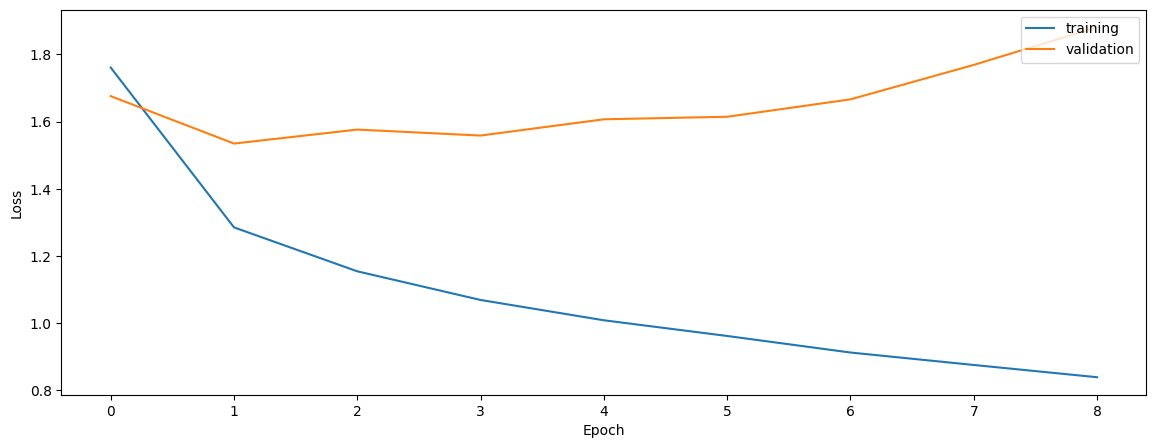

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.5277348903937559
0.4007007891657746
0.4909265782886808


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5138904469173472
0.4079794762915782
0.501679104477612


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5407743743608949
0.4463383540299353
0.5366817424422756


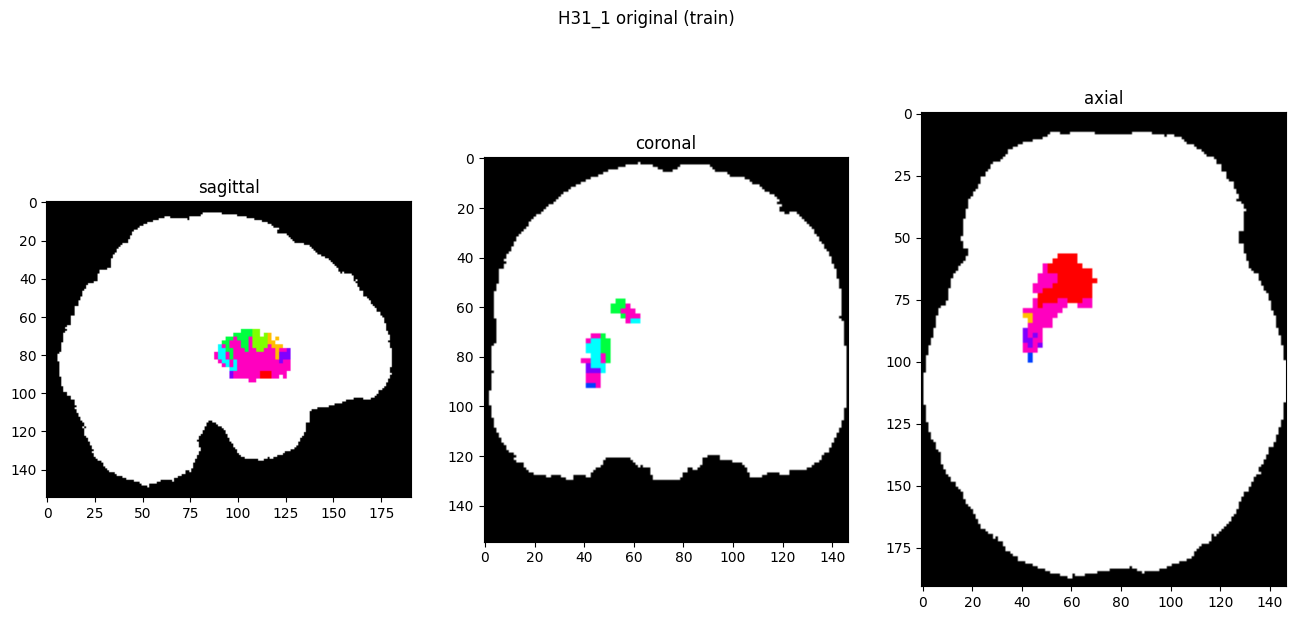

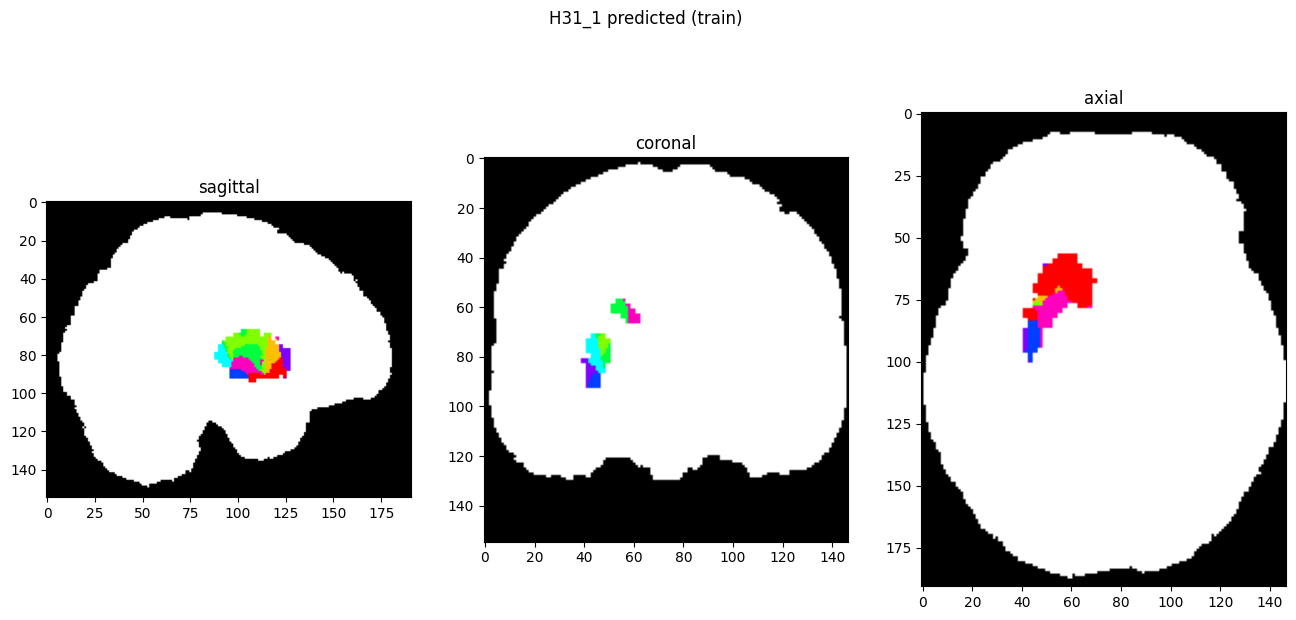

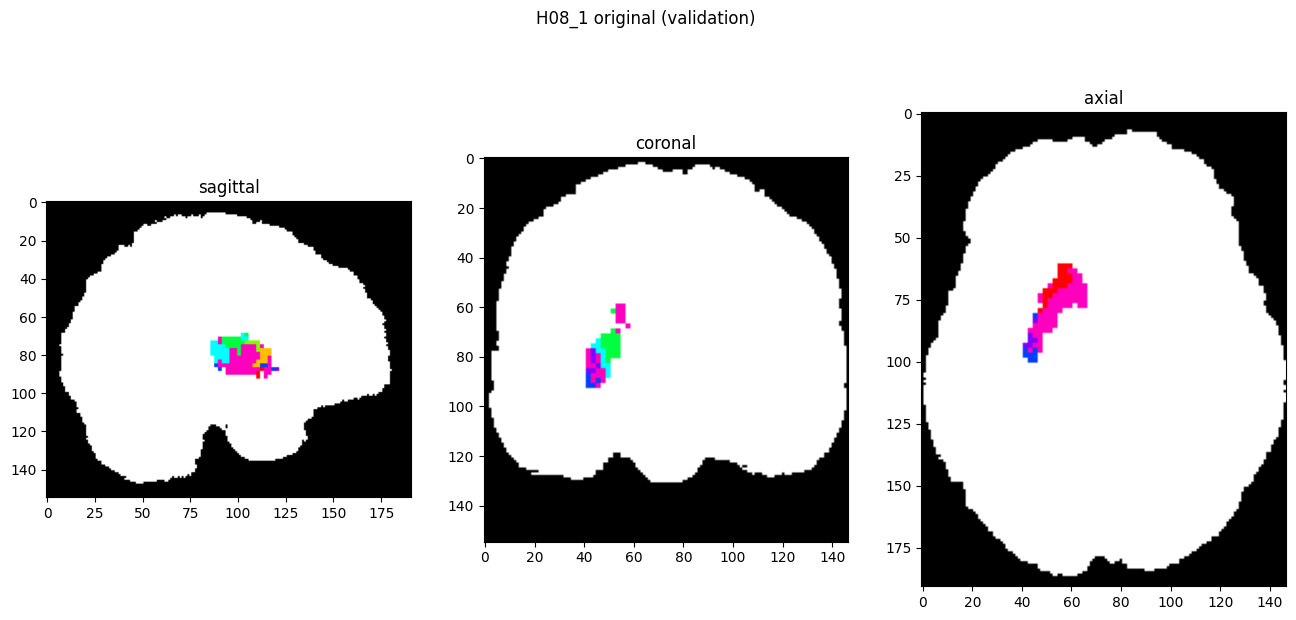

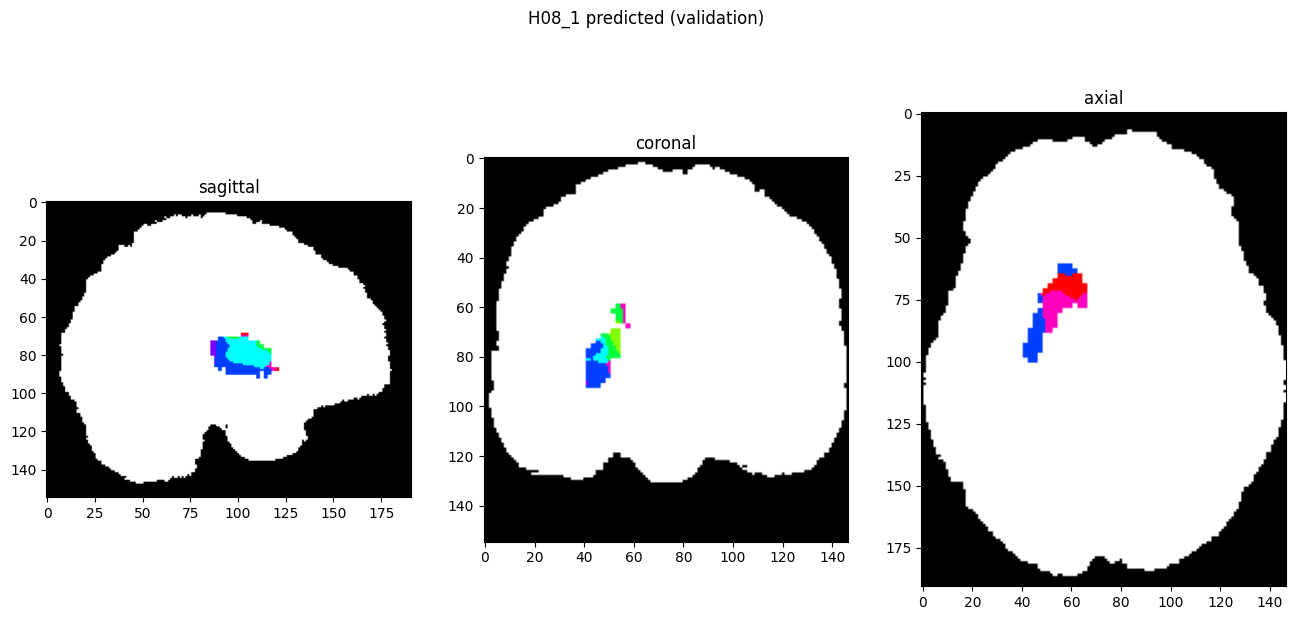

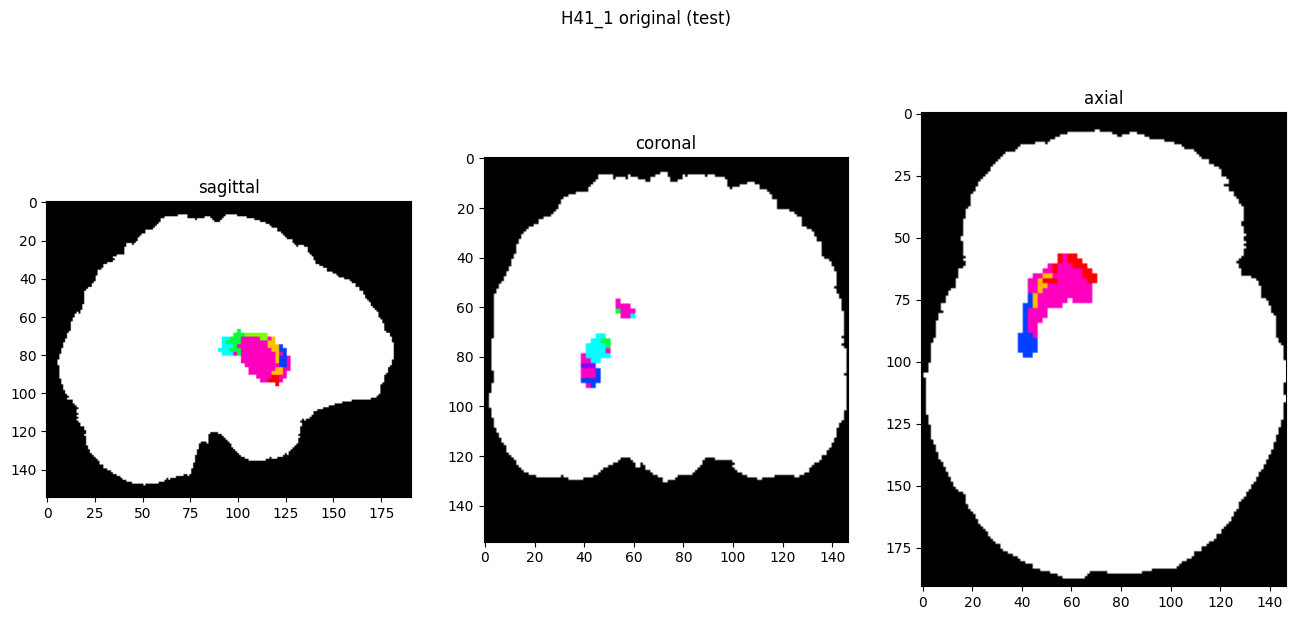

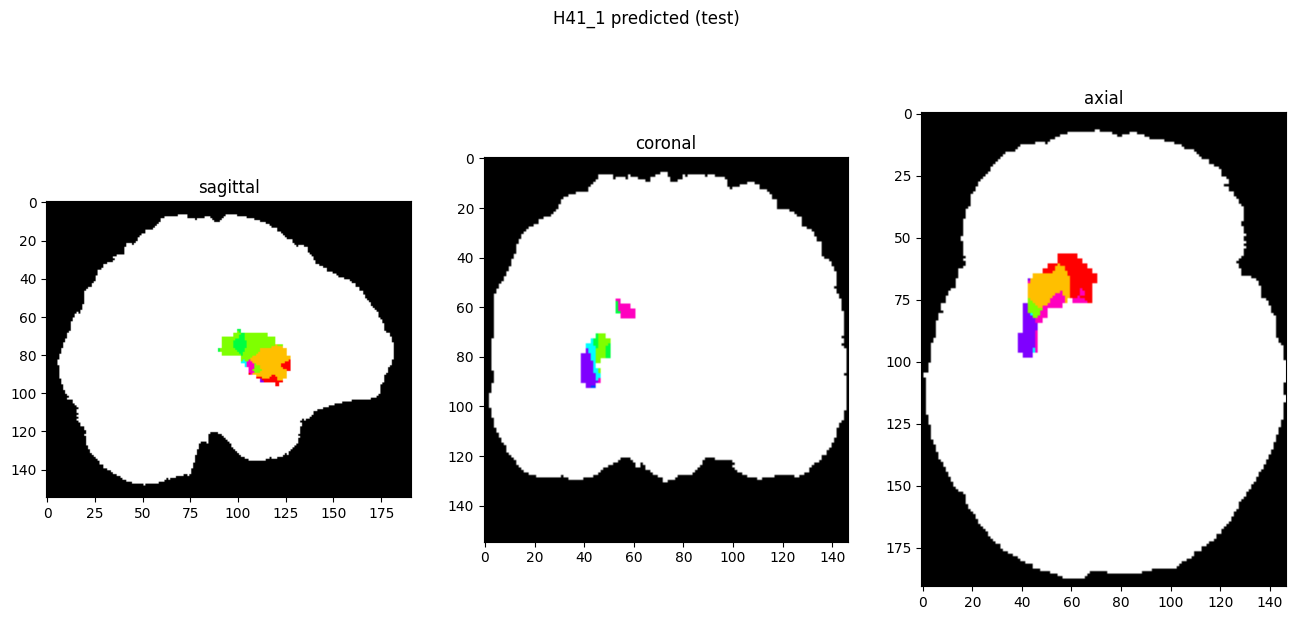

In [10]:
showResults(model, gen, threshold=0)